Notebook for testing the PLA code. 
Author: Bojian Xu, bojianxu@ewu.edu

In [1]:
import numpy as np
from IPython.display import clear_output
from numpy.random import seed as seed
from numpy.random import rand as rand
import matplotlib.pyplot as plt
import math

import pla
#import sys
#sys.path.append('..')

from utils import MyUtils

In [2]:
seed()

In [3]:
n = 2000 #number of samples
epochs = 1000  # number of epoches for the pocket based run

In [4]:
r = 2  # Z space degree   #only support: degree <= 4 for demo purpose. Don't have time to code out the generic form for any degree

In [5]:
delta = 0.01   # a parameter related to data plotting

In [6]:
messed  = True       # generate a few outliers or not
#messed = False 
mess_percent = 0.02  # percentage of outliers 

In [7]:
# a function that plots the classifer curve

def display_w_2D(w, color, degree = 1):
    ''' only support: degree <= 4 for demo purpose
        Don't have time to code out the generic form for any degree
    '''
    xrange = np.arange(0.0, 1.0, delta)
    yrange = np.arange(0.0, 1.0, delta)
    x1, x2 = np.meshgrid(xrange,yrange)
    
    if degree == 1:
        F = w[0] + w[1] * x1 + w[2] * x2
    elif degree == 2:
        F = w[0] + w[1] * x1 + w[2] * x2 \
            + w[3] * x1 * x1 + w[4] * x1 * x2 + w[5] * x2 * x2                 
    elif degree == 3:
        F = w[0] + w[1] * x1 + w[2] * x2 \
            + w[3] * x1 * x1 + w[4] * x1 * x2 + w[5] * x2 * x2   \
            + w[6] * x1 * x1 * x1 + w[7] * x1 * x1 * x2 + w[8] * x1 * x2 * x2 + w[9] * x2 * x2 * x2    
    elif degree == 4:
        F = w[0] + w[1] * x1 + w[2] * x2 \
            + w[3] * x1 * x1 + w[4] * x1 * x2 + w[5] * x2 * x2   \
            + w[6] * x1 * x1 * x1 + w[7] * x1 * x1 * x2 + w[8] * x1 * x2 * x2 + w[9] * x2 * x2 * x2\
            + w[10] * x1 * x1 * x1 * x1 + w[11] * x1 * x1 * x1 * x2 + w[12] * x1 * x1 * x2 * x2 + w[13] * x1 * x2 * x2 * x2 + w[14] * x2 * x2 * x2 * x2

    else:
        print('Z space degree is too high. Not supported now\n')
        quit()

    plt.contour(x1, x2, (F), [0], colors = color)

In [8]:
# a function that  generates a w_star, the classifer that the PLA will try to find
def w_star_gen_2d(degree = 1):
    ''' only suppot degree <= 4 for demo purpose. 
        Don't have time to code out the generic form for any degree
    '''
    if degree == 1:
        w_star = rand(3,1) * np.sign(rand(3,1)-0.5)
    elif degree == 2:
        w_star = rand(6,1) * np.sign(rand(6,1)-0.5)
    elif degree == 3:
        w_star = rand(10,1) * np.sign(rand(10,1)-0.5)
    elif degree == 4:
        w_star = rand(15,1) * np.sign(rand(15,1)-0.5)
    
    else:
        print('Z space degree is too high. Not supported now\n')
        quit()

    return w_star

### If you do not see one or multiple green line(s) being displayed in the result of the next cell, run the cell again until you see such a green line. 

w_star: 
 [[ 0.7389874 ]
 [-0.71127765]
 [-0.96458633]
 [ 0.56873005]
 [-0.64874696]
 [ 0.36116833]]


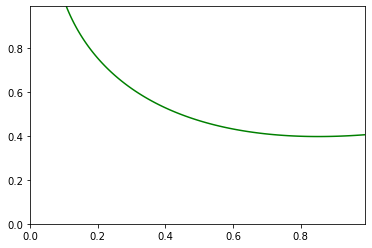

In [20]:
# randomly generate a target weight vector the PLA is going to search for
w_star = w_star_gen_2d(degree = r)
display_w_2D(w_star, color='green', degree = r)
print('w_star: \n', w_star)

In [21]:
# randomly generate the features of n samples. 
X = rand(n,2) 
Z = MyUtils.z_transform(X, degree = r)
Z = np.insert(Z, 0, 1, axis = 1)  # add the bias column

#create the label array
y = np.sign(Z @ w_star)
to_delete = [] #index of rows to be deleted because those points sit on w_star
for i in range(n):
    if y[i] == 0:
        to_delete.append(i)

# delete those samples sitting right on w_star        
X = np.delete(X, to_delete, axis = 0)
Z = np.delete(Z, to_delete, axis = 0)
y = np.delete(y, to_delete, axis = 0)
n = n - len(to_delete)


In [22]:
# mess up mess_percent of the samples to test pocket pla      
if messed: 
    for i in range(math.floor(n * mess_percent)):
        pos = math.floor(rand()*n)
        y[pos] = y[pos] * (-1)

In [23]:
# separate + and - samples for plotting     
pos = np.empty([1,2])
neg = np.empty([1,2])
for i in range(n):
    if y[i] == 1:
        pos = np.insert(pos, 0, X[i], 0)
    else: 
        neg = np.insert(neg, 0, X[i], 0)
# delete the init/useless row which is on the bottom        
pos = np.delete(pos, -1, 0)
neg = np.delete(neg, -1, 0)

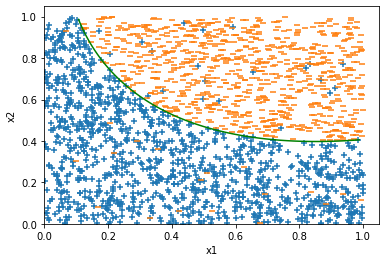

In [24]:
# display the data samples and the target classifier that PLA is tring to learn
plt.scatter(pos[:,0], pos[:,1], marker='+')
plt.scatter(neg[:,0], neg[:,1], marker='_')

display_w_2D(w_star, color = 'green', degree = r)

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Create an PLA class instance and train it by fitting it well with the training set $(\mathrm{X}, \mathrm{y})$. The learned weight vector which is an attribute of the PLA class object is the learned classifier. 

In [25]:
r_z = r    # the degree of the Z space degree where the PLA will search

perceptron = pla.PLA(degree=r_z)

if messed: 
    perceptron.fit(X, y, pocket = True, epochs = epochs)
else: 
    perceptron.fit(X, y, pocket = False)

print('w:\n', perceptron.w)



w:
 [[ 4.        ]
 [-3.60311194]
 [-1.83540331]
 [ 4.46288562]
 [-9.37924025]
 [-1.11832529]]


### Display the data samples and the target classifier (the green curve) that PLA is tring to find and the classifier the PLA has found (the red curve)


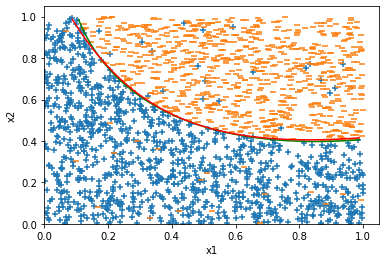

In [26]:
plt.scatter(pos[:,0], pos[:,1], marker='+')
plt.scatter(neg[:,0], neg[:,1], marker='_')

display_w_2D(w_star, color = 'green', degree = r)
display_w_2D(perceptron.w, color = 'red', degree = r_z)

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Report how many samples in the given data set $(\mathrm{X}, \mathrm{y})$ are misclassfied.

In [27]:
print('misclassified counts:', perceptron.error(X,y))
print('\n')

misclassified counts: 56


